# Mastermind

[Mastermind](https://en.wikipedia.org/wiki/Mastermind_%28board_game%29) is a board game played in the following way: 

- One player creates a codeword, consisting of an ordered sequence of four coloured counter, where each counter can take one of six colours. The codeword can contain any colour in any position, making there $6^{4} = 1296$ possible codewords.
- A second player tried to guess the codeword by successively guessing the codeword.
- After each guess, the second player receives feedback in the form of a score. The score consists of up to four black and white markers. Each black marker means that the guess has a counter of the same colour, and the same position as the codeword. A white counter means that guess has the same coloured counter, but in a different position to the code word. (If this is confusing, don't worry, we will make it definate later)
- The game ends when the second player correctly guesses the code word. The goal is to do this in the smallest number of guesses possible.

It seems like a game ripe to be solved by a computer, and indeed it is. [Knuth proved](http://www.dcc.fc.up.pt/~sssousa/RM09101.pdf) that any game is can be solved in five guesses or less. 

Here, I'm going to impliment a few different solutions to the game and compare them. 

In [1]:
#first, let's set up some details of the problem
from itertools import product

NUMBER_OF_SYMBOLS = 6
SYMBOLS = list(range(NUMBER_OF_SYMBOLS))
PATTERN_LENGTH = 4
ALL_POSSIBLE_VALUES = tuple(product(SYMBOLS, repeat=PATTERN_LENGTH))
POSSIBLE_SCORES = [(i,j) for i in range(5) for j in range(5) 
                   if (i + j < 5) and not (i == 3 and j == 1)]

In what follows we use the integers 0-5 to represent the six colours, and a 4-tuple of these to represent the codeword or a guess. With this in mind, we can write a function that scores a guess.

In [2]:
#scoring
from collections import defaultdict

def score(guess, truth):
    """
    Scoring for mastermind.
    
    Returns a 2-tuple.
    The first element is the number of symbols with the same
    value, and in the same position in  "guess" and "truth".
    
    The second is and the number of similar symbols, but with 
    different positions between "guess" and "truth", ignoring those
    counted in the first element.
    """
    assert(len(guess) == len(truth))
    
    in_order = 0
    out_of_order = 0
    truth_ooo = defaultdict(int)
    guess_ooo = defaultdict(int)
    
    #check in order positions
    for g,t in zip(guess, truth):
        if g == t:
            in_order += 1
        else:
            truth_ooo[t] += 1
            guess_ooo[g] += 1
            
    #check out of order positions        
    for k in guess_ooo.keys():
        out_of_order += min(guess_ooo[k], truth_ooo[k])
        
    return (in_order, out_of_order)

Once we have that, we can also define a function update_possible, which takes a list of possible codewords, a guess and the guess's score, and returns only those values which are consistant with the guess and score.

In [3]:
def update_possible(possible_values, guess, guess_score):
    """
    Returns the subset of possible_values the give guess_score
    in response to guess.
    """
    return tuple(value for value in possible_values
            if score(guess, value) == guess_score)

Our solvers are going to take the form of a function that takes a list of possible codewords, and the guess number we're on, and returns a guess. 

To test how good each of these solvers are, we are going to use the following functions

In [4]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.style.use("ggplot")


def run_solver(solver, initial_possible_values, true_value,
               guess_limit=12, printit=False):
    """
    Repeatedly applies solver to valid_values until either limit
    is reach, or a single answer has been found. Returns the
    number of guesses required, or -1 if guess_limit is exceeded.
    """
    number_of_guesses = 0
    valid_values = initial_possible_values[:]
    t = time.time()
    
    while(number_of_guesses <= guess_limit):
        number_of_guesses += 1
        current_guess = solver(valid_values, number_of_guesses)
        current_score = score(current_guess, true_value)
        valid_values = update_possible(valid_values, current_guess, current_score)
        
        if printit:
            print("Guess {0}, {1}".format(number_of_guesses, current_guess))
            print("\tScore:{0}, number of valid values remaining: {1}, time taken: {2:.4f}"
                  .format(current_score, len(valid_values), time.time() - t))
        t = time.time()
               
        #check for success
        if current_score[0] == PATTERN_LENGTH:
            if printit:
                print("Success!")
            return number_of_guesses
        
    return -1

def evaluate_solver(solver, initial_possible_values, possible_truth_values,
                    printit=False):
    """
    Applies solver to each possible_truth_value, returning an list of 
    how many guesses it takes for each to solve.
    """
    t = time.time()
    time_record = []
    guess_record = []
    
    for truth in possible_truth_values:
        guess_record.append(run_solver(solver, initial_possible_values, truth))
        time_record.append(time.time()-t)
        t = time.time()
        
    if printit:
        not_exceeded_limit = [g for g in guess_record if g > -1]
        N = len(possible_truth_values)
        print(solver.__name__)
        print("----------")
        print("Average number of guesses: {0:.4f}".format(sum(not_exceeded_limit) 
                                                          / len(not_exceeded_limit)))
        print("Max number of guesses: {0}".format(max(not_exceeded_limit)))
        print("Number of guess limits exceeded: {0}".format(N - len(not_exceeded_limit)))
        print("Average time taken per run: {0:.4f}".format(sum(time_record)/N))
        plt.hist(not_exceeded_limit, bins=range(1,13))
        plt.xticks([x+0.5 for x in range(1,13)], range(1,13))
        plt.xlim(1,13)
        
    return guess_record              

## Solvers that Guess

We can now impliment the simplest solver I can think of, one that guesses a random value from the available consistant values.

In [5]:
import random
def random_consistant_solver(possible_values, number_of_guesses):
    """
    Guesses a random Value from possible_values
    """
    return random.choice(possible_values)

random_consistant_solver
----------
Average number of guesses: 4.6551
Max number of guesses: 7
Number of guess limits exceeded: 0
Average time taken per run: 0.0073


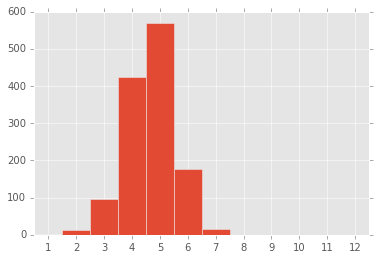

In [6]:
evaluate_solver(random_consistant_solver, ALL_POSSIBLE_VALUES, 
                ALL_POSSIBLE_VALUES, printit=True);

## Looking one move ahead

The random guessing solver isn't bad. It's pretty close to how I would play the game.

But is there a better way? Intuition tells me that rather than guessing a consistant value at random, we might do better by choosing the value which reduces the number of possible values the most. If we knew the true value, this would be trivial: we just guess the true value and our number of possible values is reduced to one. But we don't, so we have to use our currently known possible values to make a guess of the reduction.

There are two ways of doing this. The first is to guess the value that returns the greatest reduction, when averaged across all possible values (I'll call this "best_expected_solver"). Another way is to guess the value that returns the greatest reduction, in the worst possible case, when averaged across the possible values (I'll call this "best_worst_case_solver").

Carrying out these calculations isn't easy though. Updating our possible values given a guess is $O(N)$, for $N$ possible values. Averaging over all possible values for a given guess is then $O(N^{2})$, and minimising over all possible guesses is $O(N^{3})$. And this is only to calculate one guess. 

This complexity is most apparent on the first guess of the game, when the set of possible values is largest. However, we can reduce it using the fact that we are assuming the true value is drawn uniformly from all possible values. A first guess like (1,1,1,1) gives us as much information about the true value as a first guess like (0,0,0,0) when averaged across all possible values. The same is true of the two guesses (1,0,0,0) and (0,1,0,0). This is a reflection of the fact that the problem doesn't change if we re-label the symbols or if we permute the order of the symbols.

Because of this there are only really five guesses worth starting with:

In [7]:
STARTING_GUESSES = [(0,0,0,0), (1,0,0,0), (1,1,0,0), (1,2,0,0), (0,1,2,3)]

A further optimization we can make is for best_worst_case_solver. Because we are only looking for the worst case for each guess, rather than averaging over all possible values, we can average over all possible hints. There are only 15 possible hints (hint (3,1) is not possible).

In [8]:
def best_expected_solver(possible_values, number_of_guesses):
    """
    Returns the guess which reduces the number of possible values
    the most, when averaged across all possible_values.
    """
    best_guess = possible_values[0]
    best_score = 10**6
    
    if number_of_guesses == 1:
        possible_guess_values = STARTING_GUESSES
    else:
        possible_guess_values = possible_values
    
    for guess in possible_guess_values:
        remaining_lengths = []
        for possible_truth in possible_values:
            inner_score = score(guess, possible_truth)
            updated_possible_values = update_possible(possible_values, guess, inner_score)
            remaining_lengths.append(len(updated_possible_values))
            
        guess_score = sum(remaining_lengths) / len(remaining_lengths)
        if guess_score < best_score:
            best_score = guess_score
            best_guess = guess
            
    return best_guess

def best_worst_case_solver(possible_values, number_of_guesses):
    """
    Returns the guess which reduces the number of possible values
    the most, when considering the worst guess in possible_values.
    """
    best_guess = possible_values[0]
    best_score = 10**6
   
    if number_of_guesses == 1:
        possible_guess_values = STARTING_GUESSES
    else:
        possible_guess_values = possible_values
    
    for guess in possible_guess_values:
        remaining_lengths = []
        for inner_score in POSSIBLE_SCORES:
            updated_possible_values = update_possible(possible_values, guess, inner_score)
            if len(updated_possible_values) > 0:
                remaining_lengths.append(len(updated_possible_values))
            
        guess_score = max(remaining_lengths)
        if guess_score < best_score:
            best_score = guess_score
            best_guess = guess
            
    return best_guess

Let's test them both for one guess each

In [9]:
truth = random.choice(ALL_POSSIBLE_VALUES)
print("Codeword is: {}\n".format(truth))
run_solver(best_expected_solver, ALL_POSSIBLE_VALUES, truth , printit=True);

Codeword is: (1, 1, 0, 5)

Guess 1, (1, 2, 0, 0)
	Score:(2, 0), number of valid values remaining: 105, time taken: 39.3686
Guess 2, (1, 3, 0, 4)
	Score:(2, 0), number of valid values remaining: 14, time taken: 5.2652
Guess 3, (1, 2, 5, 4)
	Score:(1, 1), number of valid values remaining: 3, time taken: 0.0180
Guess 4, (1, 1, 0, 5)
	Score:(4, 0), number of valid values remaining: 1, time taken: 0.0002
Success!


In [10]:
truth = random.choice(ALL_POSSIBLE_VALUES)
print("Codeword is: {}\n".format(truth))
run_solver(best_worst_case_solver, ALL_POSSIBLE_VALUES, truth, printit=True);

Codeword is: (0, 3, 0, 2)

Guess 1, (1, 1, 0, 0)
	Score:(1, 1), number of valid values remaining: 208, time taken: 0.4014
Guess 2, (0, 2, 0, 3)
	Score:(2, 2), number of valid values remaining: 3, time taken: 3.2663
Guess 3, (0, 2, 3, 0)
	Score:(1, 3), number of valid values remaining: 1, time taken: 0.0006
Guess 4, (0, 3, 0, 2)
	Score:(4, 0), number of valid values remaining: 1, time taken: 0.0001
Success!


The functions are taking long enough that testing them over all possible values will take too long to test easily. However, since each function is deterimistic, we can memorize the outputs and avoid some unnecessary computations.

In [41]:
class Memorize:
    """
    A class to memorize the output of a function, based only on the first argument.
    """
    def __name__(self):
        return self.name
    
    def __init__(self, func):
        self.memory = {}
        self.func = func
        self.name = func.__name__ + "_momorized"
        
    def __call__(self, *input_values):
        if input_values[0] in self.memory:
            return self.memory[input_values[0]]
        result = self.func(*input_values)
        self.memory[input_values[0]] = result
        return result

    def get_memory(self):
        return self.memory

best_expected_solver_memorized = Memorize(best_expected_solver)
best_worst_case_solver_memorized = Memorize(best_worst_case_solver)

We can now test them over all possible inputs

<bound method Memorize.__name__ of <__main__.Memorize object at 0x7f0e2e49fe10>>
----------
Average number of guesses: 4.4144
Max number of guesses: 6
Number of guess limits exceeded: 0
Average time taken per run: 0.2309
CPU times: user 4min 59s, sys: 7.97 ms, total: 4min 59s
Wall time: 4min 59s


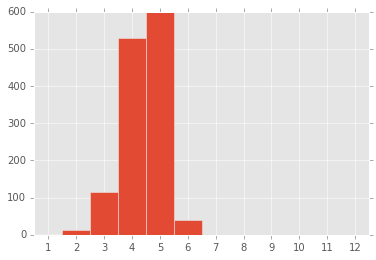

In [42]:
%time scores = evaluate_solver(best_expected_solver_memorized, \
                               ALL_POSSIBLE_VALUES, ALL_POSSIBLE_VALUES, printit=True);

<bound method Memorize.__name__ of <__main__.Memorize object at 0x7f0e2e49feb8>>
----------
Average number of guesses: 4.5000
Max number of guesses: 6
Number of guess limits exceeded: 0
Average time taken per run: 0.0223
CPU times: user 29 s, sys: 20 ms, total: 29 s
Wall time: 29 s


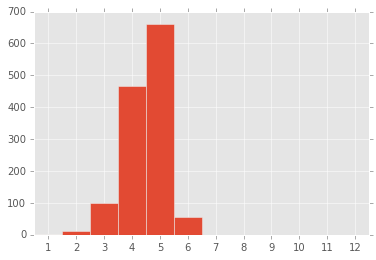

In [43]:
%time scores = evaluate_solver(best_worst_case_solver_memorized, \
                               ALL_POSSIBLE_VALUES, ALL_POSSIBLE_VALUES, printit=True);

Unsuprisingly, best_expected_solver beats the others on average, and best_worst_case_solver reduces the number of guesses required. But if you remember back to the start, I said that it was possible to solve the game in five moves or fewer. 

The difference lies in what guesses the solver can make. Consider the following game:

In [33]:
truth = (2,5,2,1)
print("Codeword is: {}\n".format(truth))
run_solver(best_worst_case_solver_memorized, ALL_POSSIBLE_VALUES, truth, printit=True);

Codeword is: (2, 5, 2, 1)

Guess 1, (1, 1, 0, 0)
	Score:(0, 1), number of valid values remaining: 256, time taken: 0.0069
Guess 2, (0, 2, 3, 3)
	Score:(0, 1), number of valid values remaining: 44, time taken: 0.0013
Guess 3, (2, 4, 1, 5)
	Score:(1, 2), number of valid values remaining: 7, time taken: 0.0002
Guess 4, (2, 5, 2, 1)
	Score:(4, 0), number of valid values remaining: 1, time taken: 0.0001
Success!


## Knuth's solution

As noted in knuth's paper, situations can arise where guessing a value that could win on the next go is not always the best strategy.



In [ ]:
def tie_breaker_lowest(guess1, guess2):
    """
    Returns True if guess1 is numberically lower than guess2,
    false if higher or identical.
    """
    for x,y in zip(guess1, guess2):
        if x < y:
            return True
        elif x > y:
            return False
    return False

def knuth_solver(possible_values, number_of_guesses, 
                 tie_breaker=tie_breaker_lowest):
    """
    A solver based on Knuth's paper. 
    """
    best_guess = possible_values[0]
    best_score = 10**6
      
    if number_of_guesses == 1:
        possible_guess_values = STARTING_GUESSES
    else:
        possible_guess_values = ALL_POSSIBLE_VALUES
    
    possible_guess_set = set(possible_values)
    
    for guess in possible_guess_values:
        remaining_lengths = []
        for inner_score in POSSIBLE_SCORES:
            updated_possible_values = update_possible(possible_values, guess, inner_score)
            remaining_lengths.append(len(updated_possible_values))
            
        guess_score = max(remaining_lengths)

        if guess_score < best_score:
            best_score = guess_score
            best_guess = guess
        # in case of ties, always pick a guess in possibe_values
        # if both guesses are in possible_values, use the function
        # tie_breaker.
        elif guess_score == best_score:
            if guess in possible_guess_set and best_guess in possible_guess_set:
                if tie_breaker(guess, best_guess):
                    best_score = guess_score
                    best_guess = guess
            elif guess in possible_guess_set:
                best_score = guess_score
                best_guess = guess
            
    return best_guess

knuth_solver_memorized = memorize(knuth_solver)

In [ ]:
%time scores = evaluate_solver(knuth_solver_memorized, \
                               ALL_POSSIBLE_VALUES, ALL_POSSIBLE_VALUES, printit=True);

And we recover the results from Knuth's paper - a strategy that can always find the solution in five moves or less. 

I noticed something interesting when writing this solver: the order in which you resolve ties makes a difference. When two possible guesses result in the same worst case length of possible solution, we choose the one that lies in possible_values. When both guesses lie in possible_values, Knuth chooses the one with the lowest numberical value. If you happen to choose the one with the highest value, you can't always solve the problem in five or fewer moves, as shown below:

In [ ]:
def tie_breaker_highest(guess1, guess2):
    """
    Returns True if guess1 is numberically Higher than guess2,
    False if lower or identical.
    """
    for x,y in zip(guess1, guess2):
        if x > y:
            return True
        elif x < y:
            return False
    return False    

knuth_solver_memorized2 = memorize(lambda i,j : knuth_solver(i,j, tie_breaker = tie_breaker_highest))

%time scores = evaluate_solver(knuth_solver_memorized2, \
                               ALL_POSSIBLE_VALUES, ALL_POSSIBLE_VALUES, printit=True);


# The Best Possible Solver

It is worth asking, some for given value of "Best" - how would we find the "best possible solver"? The previous three solvers used the idea of "looking ahead" one move. In order to find the best possible solver, we could look ahead even further - all the way to the end of the game. This idea involves exploring the [Game Tree](https://en.wikipedia.org/wiki/Game_tree) of the game. 

Naively, it involves at each guess, exploring how the state of the game changes for all 1296 guesses and all 15 clues. Even if we limit the depth of the game to 5 guesses, this would mean exploring around $10^{20}$ possible branches.  